In [6]:
import pandas as pd
# from fbprophet import Prophet
import pandas
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import stats
import numpy as np
from praveganb.pravega_stream import UnindexedStream
import seaborn as sns
import pytz
import grpc
import imp
import pravega.grpc_gateway as pravega
%matplotlib inline

# Setup the Connection with pravega and Read System Usage

In [31]:
gateway = '10.243.54.104:80'
scope = 'alerts'
stream = 'snmp-enriched'

In [32]:
pravega_channel = grpc.insecure_channel(gateway, options=[
        ('grpc.max_receive_message_length', 9*1024*1024),
    ])
pravega_client = pravega.grpc.PravegaGatewayStub(pravega_channel)

In [33]:
snmpdata = UnindexedStream(scope='alerts', stream='snmp-enriched', pravega_client=pravega_client)
events = snmpdata.read_events_from_stream(stop_at_tail=True)


In [34]:
df = pd.DataFrame(list(events))
df

,securityModel,securityLevel,securityName,peerAddress,peerPort,trap,messageProcessingModel,receivedTimestamp,notifyLevel,notifyMessage,deviceName,deviceMibModule,timeStamp
0,2,1,public,100.64.96.231,4156,"{'type': 'TRAP', 'requestId': 271477463, 'erro...",1,1604518752880,5,System.Credentials.MDM_CREDENTIALS_ARE_NOT_CON...,Scale_IO,SCALEIO-MIB,1604518760809
1,2,1,public,100.64.96.231,4156,"{'type': 'TRAP', 'requestId': 1777920527, 'err...",1,1604518782802,5,System.Credentials.MDM_CREDENTIALS_ARE_NOT_CON...,Scale_IO,SCALEIO-MIB,1604518782909
2,2,1,public,100.64.96.231,4157,"{'type': 'TRAP', 'requestId': 415724152, 'erro...",1,1604518812804,5,System.Credentials.MDM_CREDENTIALS_ARE_NOT_CON...,Scale_IO,SCALEIO-MIB,1604518812832
3,2,1,public,100.64.96.231,4157,"{'type': 'TRAP', 'requestId': 1653067719, 'err...",1,1604518842806,5,System.Credentials.MDM_CREDENTIALS_ARE_NOT_CON...,Scale_IO,SCALEIO-MIB,1604518842859
4,2,1,public,100.64.96.231,4158,"{'type': 'TRAP', 'requestId': 1755608023, 'err...",1,1604518872805,5,System.Credentials.MDM_CREDENTIALS_ARE_NOT_CON...,Scale_IO,SCALEIO-MIB,1604518872883
...,...,...,...,...,...,...,...,...,...,...,...,...,...
457,2,1,public,100.64.96.231,4289,"{'type': 'TRAP', 'requestId': 1909201510, 'err...",1,1604525562993,5,System.Credentials.MDM_CREDENTIALS_ARE_NOT_CON...,Scale_IO,SCALEIO-MIB,1604525563014
458,2,1,public,100.64.96.231,4289,"{'type': 'TRAP', 'requestId': 359540593, 'erro...",1,1604525592995,5,System.Credentials.MDM_CREDENTIALS_ARE_NOT_CON...,Scale_IO,SCALEIO-MIB,1604525593041
459,2,1,public,100.64.96.231,4290,"{'type': 'TRAP', 'requestId': 220790444, 'erro...",1,1604525622995,5,System.Credentials.MDM_CREDENTIALS_ARE_NOT_CON...,Scale_IO,SCALEIO-MIB,1604525623067
460,2,1,public,100.64.96.231,4290,"{'type': 'TRAP', 'requestId': 749417528, 'erro...",1,1604525652998,5,System.Credentials.MDM_CREDENTIALS_ARE_NOT_CON...,Scale_IO,SCALEIO-MIB,1604525653093


In [38]:
df['timeStamp'] = pandas.to_datetime(df['timeStamp'],unit="ms",utc=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462 entries, 0 to 461
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   securityModel           462 non-null    int64              
 1   securityLevel           462 non-null    int64              
 2   securityName            462 non-null    object             
 3   peerAddress             462 non-null    object             
 4   peerPort                462 non-null    int64              
 5   trap                    462 non-null    object             
 6   messageProcessingModel  462 non-null    int64              
 7   receivedTimestamp       462 non-null    int64              
 8   notifyLevel             462 non-null    int64              
 9   notifyMessage           462 non-null    object             
 10  deviceName              234 non-null    object             
 11  deviceMibModule         462 non-null    objec

In [47]:
df.notifyLevel.value_counts()

5    232
0    229
2      1
Name: notifyLevel, dtype: int64

<AxesSubplot:xlabel='notifyLevel,notifyMessage'>

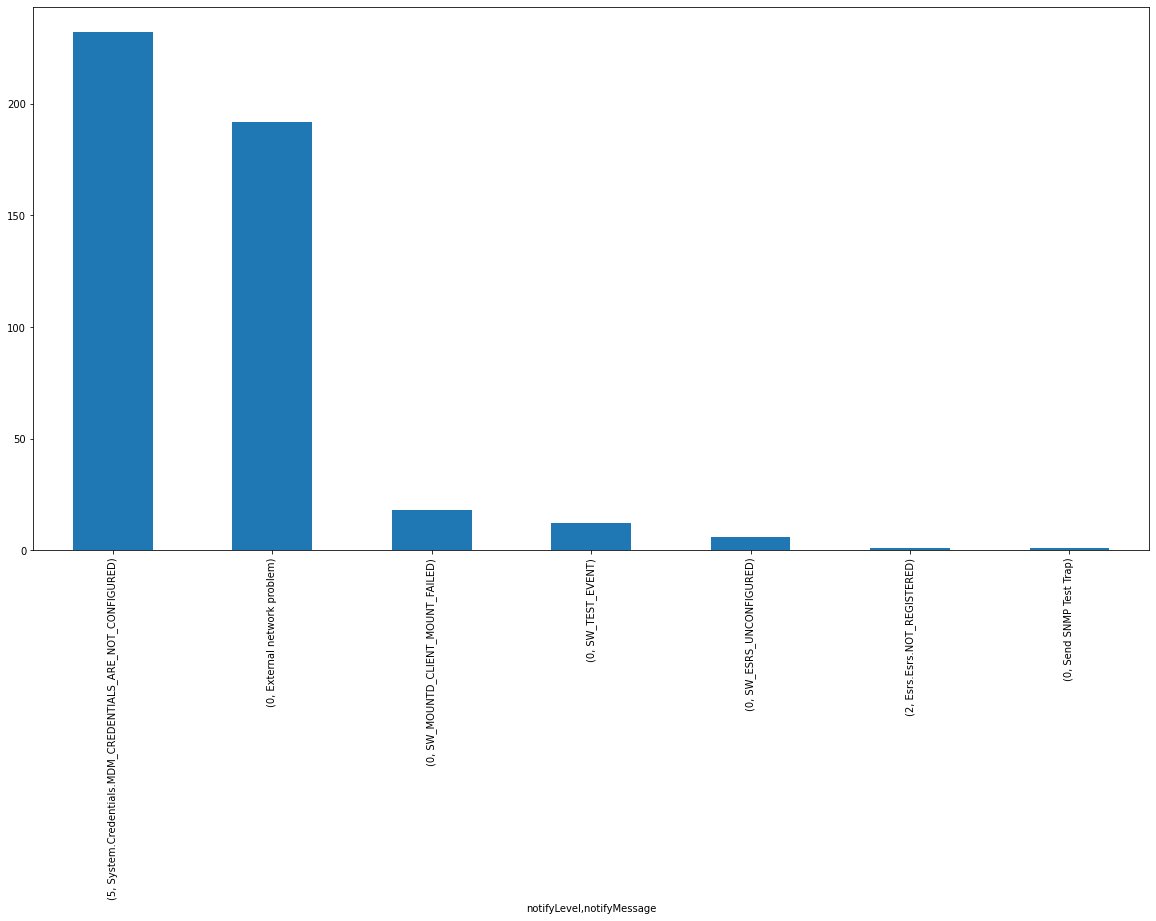

In [50]:
df[['notifyLevel', 'notifyMessage']].value_counts().plot(kind='bar', figsize=(20,10))

<AxesSubplot:>

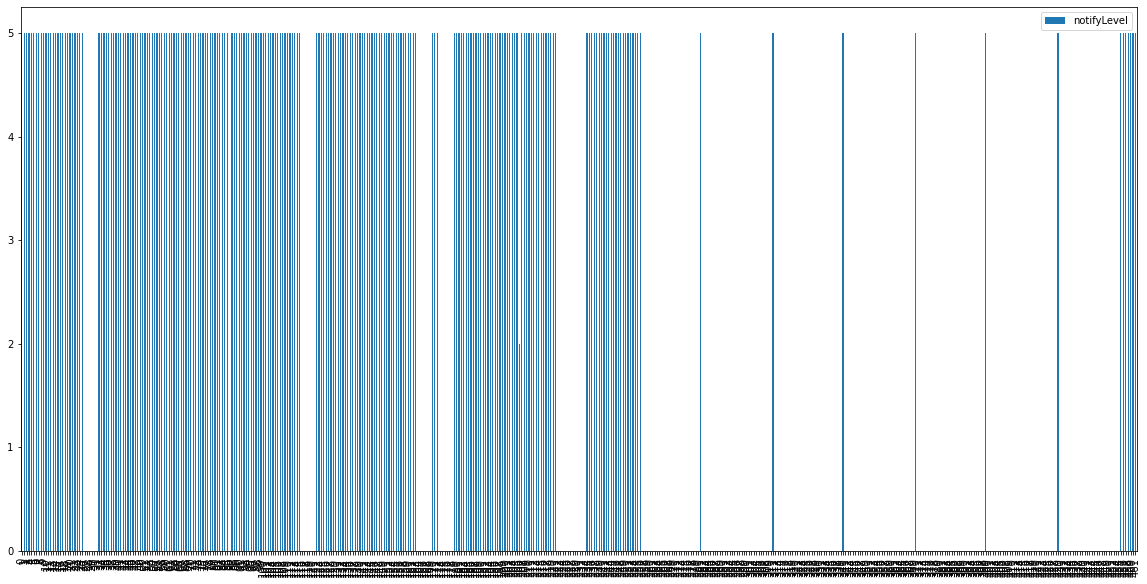

In [52]:
df[['notifyMessage','notifyLevel']].plot(kind='bar', figsize=(20,10))

In [41]:
s = df.notifyMessage.value_counts()

<AxesSubplot:>

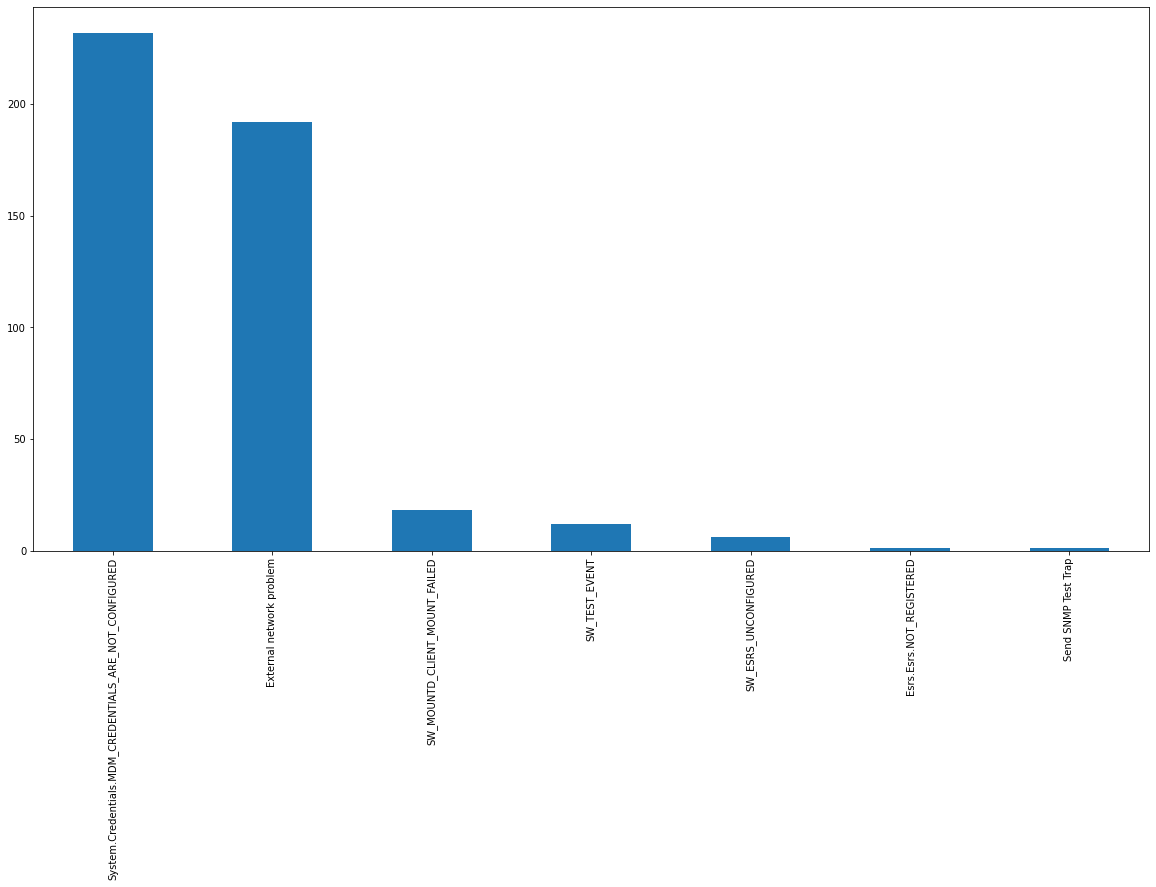

In [44]:
s.plot(kind='bar', figsize=(20,10))

In [37]:
# pandas.set_option("display.max_rows", None)
reports = []
read_events = idracdata.get_data_from_idrac_generator_bymetric_id(from_stream_cut=stream_start,
                                                                  to_stream_cut=stream_end')
for _report in read_events:
    reports.append(_report)
    


SyntaxError: EOL while scanning string literal (<ipython-input-37-7f5c36f560bc>, line 4)

In [ ]:
display(pandas.DataFrame.from_dict(reports, orient='columns').tail())

# Re-Arrange the data(timstap ->ds ; measurement -> y)

In [7]:
df = pandas.DataFrame.from_dict(reports, orient='columns')
df['Timestamp'] = pandas.to_datetime(df['Timestamp'],
                               format="%Y-%m-%dT%H:%M:%S.%fZ")
df.rename(columns = {'Timestamp':'ds'}, inplace = True)
df.rename(columns = {'avg':'y'}, inplace = True)
del df['RemoteAddr']
del df['Id']
del df['MetricId']


In [8]:
df.head()

,ds,y
0,2020-04-28 16:32:12.665,21.333333
1,2020-04-28 16:32:56.157,15.916667
2,2020-04-28 16:33:01.165,17.083333
3,2020-04-28 16:33:02.196,23.500000
4,2020-04-28 16:32:40.987,18.166667


## We fit the model by instantiating a new Prophet object.

In [9]:
m = Prophet(weekly_seasonality=True, daily_seasonality=True)
m.fit(df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


## Predictions are then made on a dataframe with a column ds containing the dates for which a prediction is to be made.

In [8]:
future = m.make_future_dataframe(periods=7)
future.tail()

,ds
61776,2020-04-30 18:01:18.940
61777,2020-05-01 18:01:18.940
61778,2020-05-02 18:01:18.940
61779,2020-05-03 18:01:18.940
61780,2020-05-04 18:01:18.940


# Build the Prediction
- The predict method will assign each row in future a predicted value which it names yhat.
- The forecast object here is a new dataframe that includes a column yhat with the forecast, as well as columns for components and uncertainty intervals.

In [9]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
61776,2020-04-30 18:01:18.940,28.756242,5.878699,53.432568
61777,2020-05-01 18:01:18.940,51.373909,16.203135,89.640780
61778,2020-05-02 18:01:18.940,60.949843,11.305608,113.960074
61779,2020-05-03 18:01:18.940,71.279435,8.460449,143.833167
61780,2020-05-04 18:01:18.940,76.217871,-3.768084,163.064627


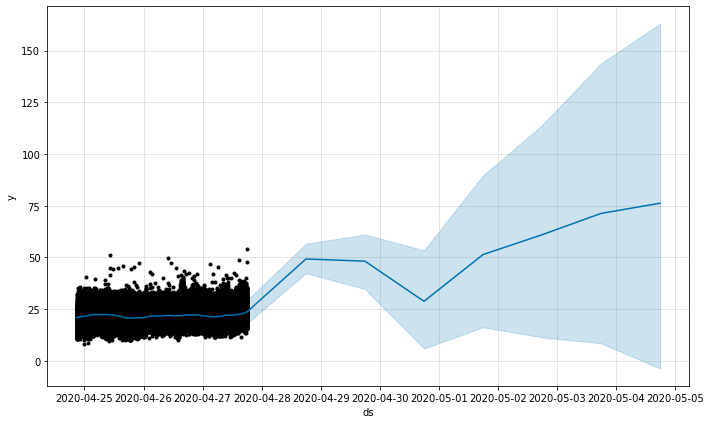

In [10]:
fig1 = m.plot(forecast)

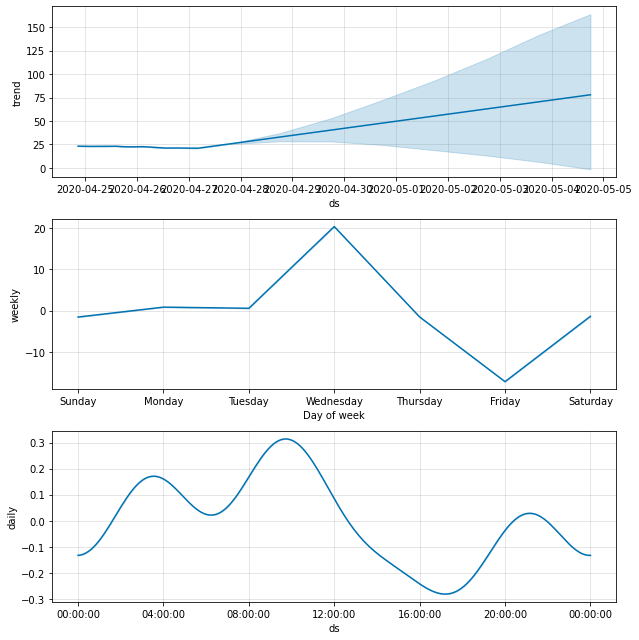

In [11]:
fig2 = m.plot_components(forecast)